In [ ]:
import torch

from transformers import PreTrainedModel
from trader_models import SGConvConfig, SGConvTrader
import datasets
from datasets import load_dataset, Dataset, DatasetDict

from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

import numpy as np

import logging
logging.disable(logging.INFO)

In [2]:
def compute_metrics(preds):
    soft_profit, soft_trade = preds.predictions
    abs_trade = np.abs(soft_trade)
    abs_trade = abs_trade.astype('float64') # half precision will cause the sum to overflow on next line
    trades = abs_trade.sum()
    
    day_profits = soft_profit.sum(axis = (1, 2))
    
    metrics = {
        'day profit': day_profits.mean(),
        'day sharpe': day_profits.mean() / day_profits.std(),
        'trade %': trades * 100 / soft_profit.size,
        
        'full trade %': (abs_trade >= .7).mean() * 100,
        'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
        'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
                          / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
        
        'medium trade %': ((abs_trade < .7) & (abs_trade >= .4)).mean() * 100,
        'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
        'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit < 0)].mean(),       
        
        'small trade %': ((abs_trade < .4) & (abs_trade >= .2)).mean() * 100,
        'small trade accuracy': (soft_profit[(abs_trade < .4) & (abs_trade >= .2)] > 0).mean() * 100,
        'small trade g/l': soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit < 0)].mean(),        
    }
    
    # round the metrics
    metrics = {k: np.format_float_positional(v, precision = 4) for k, v in metrics.items()}
    
    return metrics

In [4]:
fx = Dataset.load_from_disk('data/fx_days')

# make splits
split = fx.train_test_split(.003, shuffle = False)
# split = fx.train_test_split(.0015, shuffle = False)
valid_test = split['test'].train_test_split(.3, shuffle = False)
fx = DatasetDict({
    'train': split['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [5]:
fx

DatasetDict({
    train: Dataset({
        features: ['ohlcv', 'labels', 'future'],
        num_rows: 35213
    })
    validation: Dataset({
        features: ['ohlcv', 'labels', 'future'],
        num_rows: 74
    })
    test: Dataset({
        features: ['ohlcv', 'labels', 'future'],
        num_rows: 32
    })
})

In [6]:
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 200,
    eval_steps = 200,
    save_steps = 10000,
    report_to = "none",
    learning_rate = 1e-3,
    weight_decay = .01,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    max_grad_norm = 1,
#     fp16 = True,
)

In [7]:
config = SGConvConfig(
    n_embd = 320, n_head = 1, hidden_dropout_prob = 0
)

model = SGConvTrader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

Using 13 layers


In [8]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored

# SGCONV transformer architecture! lr of 1e-3, batch size 5 hidden size 512, 4 heads
# NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.228700,2.184106,0.0064,0.0294,6.8137,0.0311,10.4027,0.3824,0.3919,17.0037,1.1345,1.6726,39.3055,0.9694
400,2.188100,2.182916,0.0178,0.2016,4.3631,0.0042,37.5,0.4863,0.0435,29.7362,1.0239,0.2938,34.4925,1.0359
600,2.181200,2.175694,-0.0174,-0.0555,6.3118,0.5153,5.686,0.9326,0.5498,24.0470,0.9418,2.3485,49.2519,1.0864
800,2.180100,2.171566,0.0277,0.2740,5.8136,0.4061,0.2567,0.2682,0.187,3.1233,1.047,1.3893,50.9156,1.1088
1000,2.179200,2.171188,0.0387,0.3329,6.7033,0.6491,0.5141,0.4161,0.2133,7.6735,1.3133,1.5694,51.9235,0.9585
1200,2.179800,2.181060,0.0212,0.1331,6.9636,0.0068,55.3846,0.2249,0.1338,66.6407,0.7535,3.5005,52.459,0.9030
1400,2.178300,2.169340,0.0195,0.1307,6.6273,0.1186,3.0783,1.6927,0.2345,21.8764,0.9170,2.5368,52.2463,0.9278
1600,2.168000,2.169051,0.0035,0.0388,5.6617,0.5421,0.0962,0.3222,0.2572,10.1338,0.5150,1.3033,54.4924,0.9981
1800,2.164200,2.165759,0.0066,0.1157,4.8945,0.9233,1.2874,0.2826,0.1107,39.9247,0.6778,0.5312,61.6019,0.7903
2000,2.165400,2.164024,0.0064,0.0534,6.6606,0.7025,3.5179,0.6966,0.4210,38.9054,0.6059,2.5851,54.6063,0.8835


TrainOutput(global_step=8804, training_loss=2.1655000732574394, metrics={'train_runtime': 2617.1298, 'train_samples_per_second': 13.455, 'train_steps_per_second': 3.364, 'total_flos': 0.0, 'train_loss': 2.1655000732574394, 'epoch': 1.0})

In [7]:
# oanda data all pairs past 2009, overnight labels ignored

# SGCONV transformer architecture! lr of 1e-3, batch size 5 hidden size 512, 4 heads
# NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.253900,2.188456,-0.0036,-0.0232,6.2597,0.0157,14.5695,0.6227,0.5867,9.5610,1.0884,2.458,36.2449,1.0998
400,2.203800,2.178138,0.0125,0.1415,5.6864,0.0872,0.1196,0.927,0.5105,2.594,1.1356,1.1123,42.9549,1.1416
600,2.201300,2.179769,0.0234,0.2597,5.9524,0.7283,0.5154,0.746,0.231,14.1761,1.4146,0.8273,45.0214,0.9949
800,2.200600,2.198580,-0.0076,-0.0785,7.3671,0.0086,3.6585,0.6763,0.2367,10.1762,0.7261,6.6103,44.472,1.0515
1000,2.188900,2.186725,0.0209,0.1637,6.7894,1.1486,4.7476,0.8963,0.2909,42.8674,0.9228,1.1649,55.8897,0.8131
1200,2.190600,2.187392,0.0120,0.1196,5.0382,0.8751,1.537,1.5506,0.1165,22.1128,1.1316,0.5391,54.236,0.8117
1400,2.191000,2.173209,-0.0120,-0.0820,6.8619,0.5578,6.9346,0.4355,0.5691,45.2364,0.6217,3.0424,53.3964,0.876
1600,2.197100,2.169390,0.0098,0.1033,7.0964,0.9566,2.0057,0.9936,0.2105,47.0035,0.7102,2.9752,56.1700,0.9
1800,2.183300,2.168299,0.0099,0.0899,6.7017,0.9428,0.9401,0.382,0.2907,54.2324,0.7251,2.3046,54.2530,0.8996
2000,2.188000,2.167574,0.0108,0.1385,5.5074,1.0627,4.1797,1.4348,0.3262,60.1662,0.9967,1.7722,59.5258,1.0790


TrainOutput(global_step=17746, training_loss=2.178027170749416, metrics={'train_runtime': 5250.4503, 'train_samples_per_second': 13.519, 'train_steps_per_second': 3.38, 'total_flos': 0.0, 'train_loss': 2.178027170749416, 'epoch': 1.0})

In [8]:
trainer.evaluate(fx['test'])

{'eval_loss': 2.142228841781616,
 'eval_day profit': '0.06',
 'eval_day sharpe': '0.5485',
 'eval_trade %': '7.6045',
 'eval_full trade %': '1.2542',
 'eval_full trade accuracy': '10.4773',
 'eval_full trade g/l': '2.3154',
 'eval_medium trade %': '1.5332',
 'eval_medium trade accuracy': '64.2214',
 'eval_medium trade g/l': '1.2596',
 'eval_small trade %': '3.3707',
 'eval_small trade accuracy': '59.7114',
 'eval_small trade g/l': '0.9697',
 'eval_runtime': 2.2004,
 'eval_samples_per_second': 14.998,
 'eval_steps_per_second': 4.09,
 'epoch': 1.0}

In [9]:
trainer.save_model('sgconv.model')

# quick prediction test to ensure model isn't cheating

In [10]:
config = SGConvConfig(
    n_embd = 320, n_head = 1, hidden_dropout_prob = 0
)
model = SGConvTrader.from_pretrained('sgconv.model', config = config, ignore_mismatched_sizes=True).cuda().eval()

Using 13 layers


0
tensor([-23., -23., -22., -20., -21., -31., -49., -60., -49.])


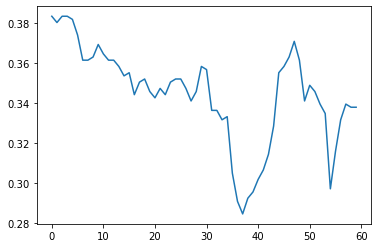

1
tensor([ -2.,  -2.,  -2.,  -1.,  -2., -11., -32., -52., -44.])


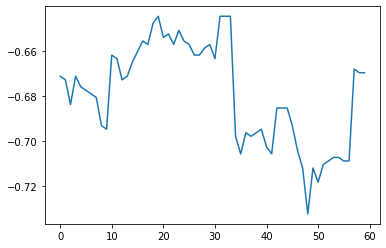

2
tensor([ -1.,  -1.,  -1.,  -1.,  -9., -29., -47., -52., -34.])


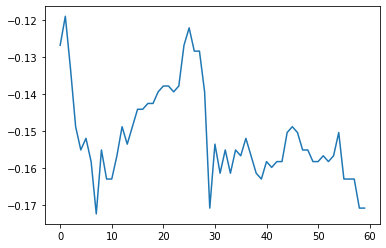

3
tensor([-26., -25., -23., -23., -27., -39., -54., -59., -46.])


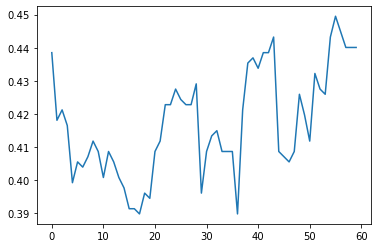

4
tensor([  5.,   6.,   5.,   4.,  -0.,  -6., -14., -17.,  -7.])


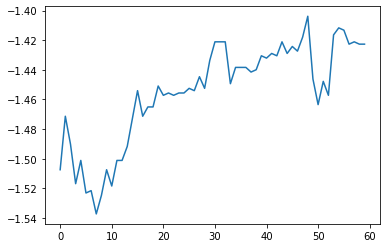

5
tensor([  0.,   3.,   7.,  10.,   9.,  -7., -29., -36., -24.])


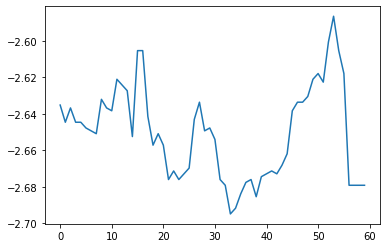

6
tensor([  2.,   5.,   6.,   8.,   6.,  -3., -11.,  -9.,   3.])


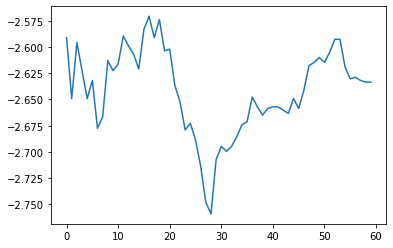

7
tensor([ -6.,  -5.,  -5.,  -4.,  -9., -17., -24., -24., -18.])


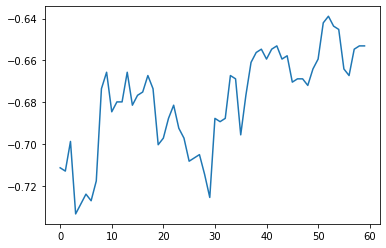

8
tensor([-22., -21., -20., -20., -19., -23., -24., -21., -19.])


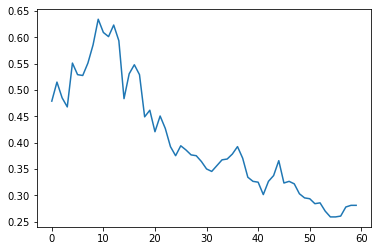

9
tensor([ -3.,  -4.,  -4.,  -5.,  -9., -15., -23., -30., -30.])


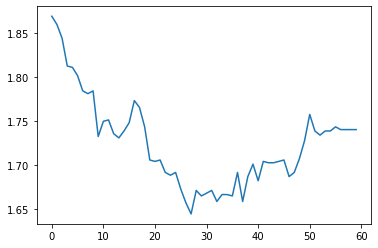

10
tensor([ -9.,  -9.,  -9.,  -8., -11., -15., -25., -39., -36.])


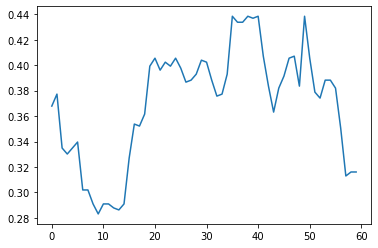

11
tensor([-22., -25., -26., -27., -30., -32., -36., -39., -36.])


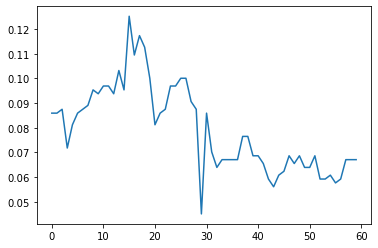

12
tensor([ 12.,  11.,  11.,  12.,   9.,  -2., -13., -21., -16.])


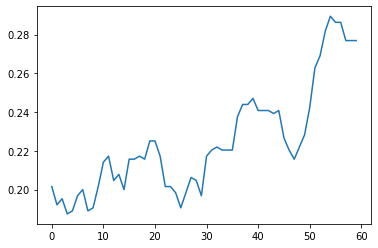

13
tensor([ -3.,  -1.,   0.,   1.,  -4., -14., -30., -47., -40.])


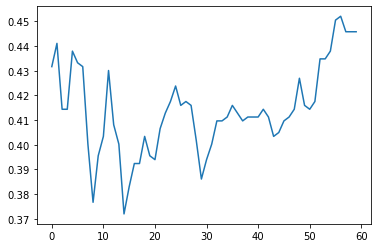

14
tensor([-20., -19., -18., -17., -19., -24., -34., -45., -43.])


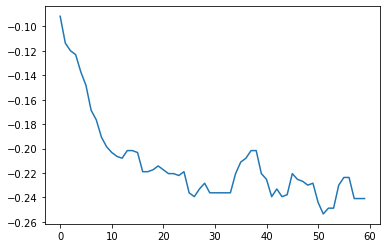

15
tensor([ -8., -11., -11.,  -8., -10., -22., -42., -54., -50.])


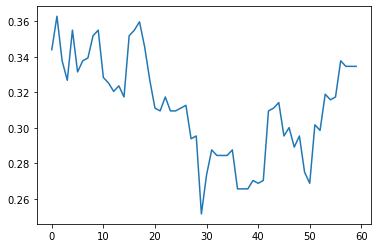

16
tensor([ 11.,  10.,  11.,  12.,  11.,   4., -13., -27., -24.])


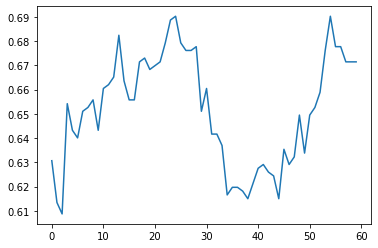

17
tensor([-24., -25., -24., -23., -24., -33., -43., -52., -45.])


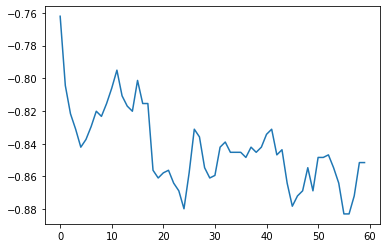

18
tensor([  8.,   8.,   9.,   8.,   3., -10., -20., -21.,  -8.])


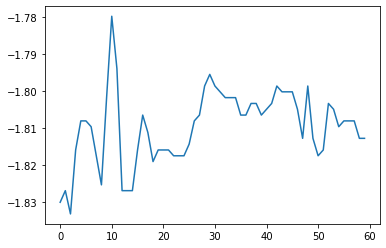

19
tensor([-30., -31., -30., -29., -29., -34., -45., -59., -58.])


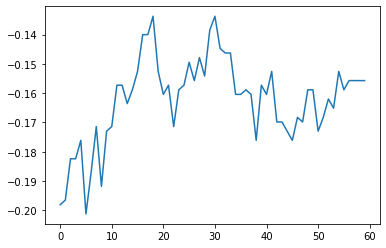

In [30]:
import matplotlib.pyplot as plt

for day in range(20):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:]).unsqueeze(0).cuda()
    test_futures = torch.tensor(fx['validation']['future'][day][:]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][21*60:22*60])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day)[0][21*60]
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
        print((pred.cpu() * 100).round())
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

0
tensor([-23., -23., -22., -20., -21., -31., -49., -60., -49.])


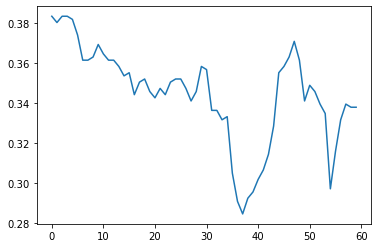

1
tensor([ -2.,  -2.,  -2.,  -1.,  -2., -11., -32., -52., -44.])


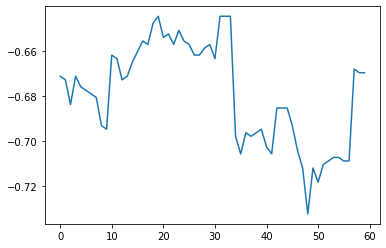

In [29]:
import matplotlib.pyplot as plt

for day in range(2):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:21*60 + 1]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][21*60:22*60])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day)[0][-1]
        
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
#         plt.pcolormesh(pred.cpu().unsqueeze(0))
        plt.show()
        print((pred.cpu() * 100).round())
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

# TODO: graph these instead of showing raw data (maybe even on same plot or at least side by side)

In [13]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)
soft_profit, soft_trade = trainer.predict(fx['validation']).predictions

In [14]:
(soft_profit.sum(axis = (1, 2)) < 0).mean()

0.28378378378378377

In [15]:
soft_profit.sum(axis = (1, 2)).std()

0.09555529

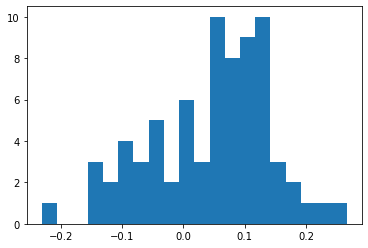

In [16]:
import matplotlib.pyplot as plt

plt.hist(soft_profit.sum(axis = (1, 2)), bins = 20)
plt.show()

In [33]:
# full trade percent on 24 hours
(((np.abs(soft_trade) > .1) & (np.abs(soft_trade) < 10)).mean(axis = (0, 2)).reshape(-1, 60).mean(axis = 1) * 100).round()

array([17.,  6.,  6., 11., 15., 15., 13.,  7.,  5.,  4.,  6., 10., 10.,
        8.,  6.,  5.,  6.,  9., 11., 17., 46., 74., 82., 39.])

In [34]:
# full trade accuracy on 24 hours
np.nanmean(np.where(((np.abs(soft_trade) > .1) & (np.abs(soft_trade) < 10)), soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

array([0.40275186, 0.46063868, 0.55635682, 0.52981041, 0.54790336,
       0.54172983, 0.5270297 , 0.51655437, 0.53305492, 0.54134752,
       0.48288697, 0.53898274, 0.51884984, 0.53191789, 0.5318951 ,
       0.46367456, 0.56323062, 0.49508013, 0.53322985, 0.52217115,
       0.54666026, 0.57110155, 0.56155905, 0.43126552])

In [35]:
# full trade profit on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > .1, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

array([-2.10814123e-05, -1.06516654e-05,  5.52188840e-06,  3.00124543e-06,
        3.53466044e-06,  4.16922830e-06,  4.74824492e-06, -8.59775753e-07,
       -8.78359879e-06,  5.23349854e-06, -1.59995416e-05,  3.53835253e-06,
        1.01278265e-05,  1.55705748e-05, -2.21899700e-06, -1.47787496e-05,
        1.55041562e-05, -1.95711573e-06,  1.31643656e-05,  1.11675454e-05,
        3.87947375e-06,  2.57943175e-05,  6.04900597e-05,  6.12566828e-06],
      dtype=float32)

In [31]:
# percent full trades on all timeframes
(np.abs(soft_trade) > .3).mean(axis = (0, 1))

array([0.03062125, 0.03771584, 0.04359047, 0.04885511, 0.0565503 ,
       0.06463964, 0.06871246, 0.05808934, 0.04611486])

In [32]:
# full trade accuracy on all timeframes
np.nanmean(np.where(np.abs(soft_trade) > .3, soft_profit > 0, np.nan), axis = (0, 1))

array([0.29941771, 0.4120428 , 0.46652314, 0.4986554 , 0.53966147,
       0.56837979, 0.58959301, 0.5914378 , 0.57651608])

In [27]:
# full trade gain on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .3) & (soft_profit > 0), soft_profit, np.nan), axis = (0, 1))

array([0.00041037, 0.00019796, 0.00042804, 0.00019042, 0.00047982,
       0.00034682, 0.00069093, 0.00077587, 0.00054583], dtype=float32)

In [28]:
# full trade loss on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .3) & (soft_profit < 0), soft_profit, np.nan), axis = (0, 1))

array([-0.00027507, -0.00020037, -0.00037731, -0.00017688, -0.00045553,
       -0.00035546, -0.00069417, -0.00074313, -0.00042752], dtype=float32)

In [21]:
# del trainer
# del model
# torch.cuda.empty_cache()

# Appendix

## SGConv Experiments

In [7]:
# oanda data all pairs past 2009

# SGCONV transformer architecture! lr of 1e-3, batch size 5 hidden size 512, 4 heads
# NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.240400,2.185881,-0.0195,-0.1244,8.1630,0.6525,11.4893,0.5389,1.6943,22.0198,0.9940,2.9776,41.627,1.0287
400,2.197200,2.165978,0.0212,0.1185,7.9601,0.6963,0.2695,1.2043,0.6476,9.0324,1.3131,3.1307,48.7494,1.1110
600,2.195300,2.168291,0.0295,0.2915,6.2947,0.9311,0.2464,0.6667,0.4372,7.7272,1.3352,0.8152,34.3310,1.0722
800,2.194700,2.189220,-0.0031,-0.0233,9.3727,0.0064,19.6721,0.3869,1.5050,16.2394,0.8599,10.9010,45.5354,1.061
1000,2.181100,2.175700,0.015,0.0959,7.7666,1.7328,2.7861,0.6795,0.3101,30.9011,1.2570,1.9119,50.2509,0.8763
1200,2.184100,2.175899,0.0053,0.0603,5.8772,1.2315,1.6679,1.7719,0.3641,14.2612,1.3344,0.6392,38.7765,0.932
1400,2.183400,2.164834,-0.0139,-0.0812,7.1664,0.6515,5.6178,0.9303,0.8768,35.6523,0.6654,3.6396,51.9754,0.8327
1600,2.190400,2.161458,-0.0071,-0.052,7.8329,0.8018,3.6411,0.9195,0.5217,36.3982,0.5668,3.9889,53.7054,0.8903
1800,2.174900,2.153806,0.0102,0.0904,7.5812,1.4889,0.3782,0.3971,0.4,53.0761,0.8308,2.8791,54.7950,0.8866
2000,2.179400,2.150973,0.0141,0.1397,6.3284,1.6453,2.2435,1.5680,0.4902,65.4967,1.1894,2.0074,62.0507,1.0132


TrainOutput(global_step=17746, training_loss=2.16817844699983, metrics={'train_runtime': 16366.3096, 'train_samples_per_second': 4.337, 'train_steps_per_second': 1.084, 'total_flos': 0.0, 'train_loss': 2.16817844699983, 'epoch': 1.0})

In [9]:
# oanda data

# SGCONV transformer architecture! lr of 1e-3, batch size 8 hidden size 320, 1 head
# NO dropout, weight decay
# NO diagonal attention allowed, NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.210500,2.171260,-0.01,-0.0719,5.3201,0.4756,1.2936,0.7324,0.5752,8.1581,1.1005,0.9064,30.9789,1.1299
400,2.170500,2.160216,0.0393,0.3422,6.9082,0.8293,0.0251,0.7456,0.1713,2.4954,0.8416,1.1363,49.9541,1.2737
600,2.168800,2.160419,0.0167,0.1641,7.8999,0.8098,0.0129,0.2321,0.3131,5.2614,0.7012,3.2679,51.7262,0.9372
800,2.162600,2.153858,-0.0048,-0.0378,6.3985,0.942,0.3099,1.1583,0.5256,14.5606,0.9703,1.4190,55.1988,0.7953
1000,2.155600,2.152036,0.0029,0.0220,6.4033,1.1714,4.1570,0.511,0.5486,37.9966,0.7135,1.8075,53.5275,0.7664
1200,2.161800,2.148250,0.0249,0.3081,6.5952,1.4711,0.3473,0.1748,0.317,60.0987,1.0863,2.4341,61.0906,0.9494
1400,2.153100,2.147601,0.0361,0.2121,8.5314,1.4307,0.2988,1.0577,0.2738,62.7951,0.7730,3.4826,59.5719,0.9755
1600,2.158700,2.147372,-0.0039,-0.0418,6.9273,1.2688,0.,nan,0.2213,4.3827,0.2958,2.2188,53.5598,0.8021
1800,2.161500,2.148000,0.0188,0.2717,6.3906,1.4182,1.9778,3.6387,0.5749,62.2778,1.3274,2.2574,60.0166,1.0657
2000,2.153700,2.143505,0.0272,0.2621,7.5424,1.4698,3.3698,0.5353,1.4021,62.7649,1.1608,3.9239,57.2066,0.9270


<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),


TrainOutput(global_step=4402, training_loss=2.156417083003639, metrics={'train_runtime': 2489.5752, 'train_samples_per_second': 14.144, 'train_steps_per_second': 1.768, 'total_flos': 0.0, 'train_loss': 2.156417083003639, 'epoch': 1.0})